In [2]:
import torch
import wandb
import numpy as np
import pandas as pd
import transformers
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from torch import nn
from tqdm import tqdm
from datasets import load_dataset
from torchvision import transforms, models
from transformers import BertTokenizer
from transformers import DetrImageProcessor, DetrForObjectDetection
import torchvision.transforms as T
import torch
# print(torch.cuda.is_available())  # Should return True
# print(torch.cuda.device_count()) # Should return the number of GPUs
# print(torch.cuda.current_device()) # Should return the current GPU ID
# print(torch.cuda.get_device_name(0)) # Should print the GPU name

In [3]:
import shutil

# Source path (where the uploaded file is located in the input directory)
source_path = '/kaggle/input/features/detr_features.pkl'

# Destination path (output directory)
destination_path = '/kaggle/working/'

shutil.copy(source_path, destination_path)

print(f"File moved to {destination_path}")


File moved to /kaggle/working/


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# def set_seed(seed):
#     try:
#         torch.manual_seed(seed)
#         if torch.cuda.is_available():
#             torch.cuda.manual_seed_all(seed)
#         torch.backends.cudnn.deterministic = True
#         torch.backends.cudnn.benchmark = False
#     except RuntimeError as e:
#         print(f"Error while setting seed: {e}")


In [5]:

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [6]:
from kaggle_secrets import UserSecretsClient
api_key = "wandb-api-key"
wandb.login(key=UserSecretsClient().get_secret(api_key), relogin=True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
# import os

# # Specify the file you want to delete
# file_path = '/kaggle/working/detr_features.pkl'
# if os.path.exists(file_path):
#     os.remove(file_path)
#     print(f"{file_path} has been deleted.")
# else:
#     print(f"{file_path} does not exist.")


/kaggle/working/detr_features.pkl does not exist.


In [7]:
# import os
# import pickle
# from tqdm import tqdm
# from PIL import Image
# import torch

# def precompute_detr_features(dataset, detr_processor, detr_model, feature_path):
#     if os.path.exists(feature_path):
#         print(f"Loading precomputed features from {feature_path}")
#         with open(feature_path, "rb") as f:
#             detr_features = pickle.load(f)
#     else:
#         print("Precomputing DETR features...")
#         detr_features = {}
#         for idx in tqdm(range(len(dataset))):
#             image_id = dataset.data.iloc[idx]['image_id']
#             image_path = os.path.join(dataset.image_folder, f"{image_id}.png")
#             image = Image.open(image_path).convert('RGB')

#             with torch.no_grad():
#                 boxes, features = extract_detr_features(image, detr_processor, detr_model)
#             detr_features[image_id] = (boxes.cpu(), features.cpu())

#         # Save features to disk
#         with open(feature_path, "wb") as f:
#             pickle.dump(detr_features, f)
#         print(f"Features saved to {feature_path}")

#     return detr_features

# # Path to save precomputed features
# feature_path = "/kaggle/working/detr_features.pkl"

# # Precompute features for the training dataset
# detr_features = precompute_detr_features(train_dataset, detr_processor, detr_model, feature_path)


In [8]:
# def extract_detr_features(self, image):
#     """
#     Extracts features and bounding boxes using the DETR model.
#     """
#     # Preprocess the image using the DETR processor
#     inputs = self.detr_processor(images=image, return_tensors="pt")

#     # Perform inference to get outputs
#     with torch.no_grad():
#         outputs = self.detr_model(**inputs)

#     # Extract last hidden state (features) and bounding boxes
#     features = outputs.last_hidden_state.squeeze(0).detach().cpu().numpy()
#     boxes = outputs.pred_boxes.squeeze(0).detach().cpu().numpy()
#     return boxes, features




In [7]:
import os
import pickle
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer


class VQADataset(Dataset):
    def __init__(self, csv_file, image_folder, detr_processor, detr_model, transform=None, feature_path="detr_features.pkl"):
        self.data = pd.read_csv(csv_file)
        self.data = self.data.sample(n=5000, random_state=42)  # Random 5000 samples
        self.image_folder = image_folder
        self.transform = transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.feature_path = feature_path
        self.detr_processor = detr_processor
        self.detr_model = detr_model
        self.detr_features = {}
        self.label_map = self.create_label_map()
        self.data['label'] = self.data['answer'].apply(lambda x: self.label_map[x.strip()])
        self.indices = list(range(len(self.data)))
        
        # Preload or compute DETR features
        self.load_or_compute_detr_features()

    def create_label_map(self):
        """
        Create a mapping from answers to integer labels.
        """
        unique_answers = sorted(self.data['answer'].unique())
        # print(self.data.head(5))
        print(f'unique ans {len(unique_answers)}')
        # print(f"data[answer]: {self.data['answer']}")
        # print(f"label: {self.data['label']}")
        return {answer: idx for idx, answer in enumerate(unique_answers)}

    def load_or_compute_detr_features(self):
        """
        Load or compute DETR features with feature compression.
        """
        if os.path.exists(self.feature_path):
            with open(self.feature_path, "rb") as f:
                self.detr_features = pickle.load(f)
        else:
            # Compute DETR features only for unique images
            unique_image_ids = self.data['image_id'].unique()
            for image_id in unique_image_ids:
                image_path = os.path.join(self.image_folder, f"{image_id}.png")
                image = Image.open(image_path).convert('RGB')
                boxes, features = self.extract_detr_features(image)
                self.detr_features[image_id] = (boxes.astype(np.float16), features.astype(np.float16))

            with open(self.feature_path, "wb") as f:
                pickle.dump(self.detr_features, f)

    def extract_detr_features(self, image):
        """
        Extract DETR features and bounding boxes from the image.
        """
        inputs = self.detr_processor(images=image, return_tensors="pt")
        outputs = self.detr_model(**inputs)
        features = outputs.last_hidden_state.squeeze(0).detach().cpu().numpy()
        boxes = outputs.pred_boxes.squeeze(0).detach().cpu().numpy()
        return boxes, features

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Return a single data point without tokenizing the question.
        """
        row = self.data.iloc[idx]
        image_id = row['image_id']
        question = row['question']
        label = row['label']

        # Load DETR features
        if image_id not in self.detr_features:
            raise ValueError(f"DETR features for image {image_id} not found.")
        boxes, features = self.detr_features[image_id]

        # Load and preprocess image
        image_path = os.path.join(self.image_folder, f"{image_id}.png")
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, question, label, boxes, features


def collate_fn(batch, tokenizer):
    """
    Custom collate function for batch processing with tokenization.
    """
    images, questions, labels, boxes, features = zip(*batch)

    images = torch.stack(images, dim=0)
    
    # Tokenize questions as a batch
    tokenized = tokenizer(
        list(questions),
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )
    input_ids = tokenized['input_ids']
    attention_mask = tokenized['attention_mask']

    # Convert labels to tensor
    labels = torch.tensor(labels)
    boxes = torch.tensor(boxes, dtype=torch.float32)
            # print(f'box {boxes.shape}')

    features = torch.tensor(features, dtype=torch.float32)
    return images, input_ids, attention_mask, labels, boxes, features


# Usage example:
# dataset = VQADataset(...)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# dataloader = DataLoader(dataset, batch_size=32, collate_fn=lambda x: collate_fn(x, tokenizer))


In [8]:
import torch
from torchvision import transforms
from torch.utils.data import random_split

# Define the image transformation
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize to match pretrained model requirements
        std=[0.229, 0.224, 0.225]
    )
])

# Initialize the full dataset
csv_file = "/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_train.csv"  # Replace with the actual path
image_folder = "/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images"      # Replace with the actual path
feature_path = "/kaggle/working/detr_features.pkl"    # Path to save or load DETR features

# Initialize DETR processor and model
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Set DETR model to evaluation mode
detr_model.eval()

full_dataset = VQADataset(
    csv_file=csv_file,
    image_folder=image_folder,
    detr_processor=detr_processor,
    detr_model=detr_model,
    transform=image_transform,
    feature_path=feature_path
)

# Split dataset into train and validation
train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: collate_fn(x, tokenizer),
    num_workers=4
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda x: collate_fn(x, tokenizer),
    num_workers=4
)


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

unique ans 802


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/tmp/ipykernel_23/3860894670.py:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  boxes = torch.tensor(boxes, dtype=torch.float32)


tensor([[  101,  2054,  2003,  2006,  1996,  2187,  2217,  1997,  1996, 22497,
           102,     0,     0,     0],
        [  101,  2054,  2003,  1999,  2392,  1997,  1997,  1996,  2250,  4650,
          2121,   102,     0,     0],
        [  101,  2054,  2003,  1996,  4874,  2006,  1996,  2723,  1999,  2392,
          1997,  1996,  2813,   102],
        [  101,  2054,  2003,  5112,  2006,  1996,  2813,  1999,  1996,  2157,
          2217,   102,     0,     0],
        [  101,  2054,  2003,  2006,  1996,  3242,   102,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  2054,  2024,  1996,  5200,  2485,  2000,  1996,  4675,   102,
             0,     0,     0,     0],
        [  101,  2054,  2003,  2157,  1997, 17428,   102,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  2054,  2003,  1999,  2392,  1997,  1996,  3608,   102,     0,
             0,     0,     0,     0]])


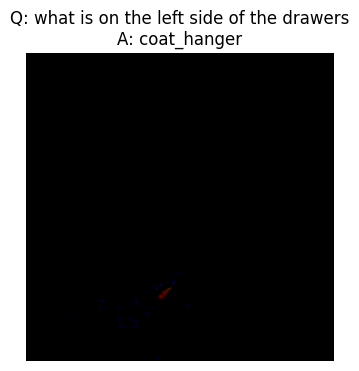

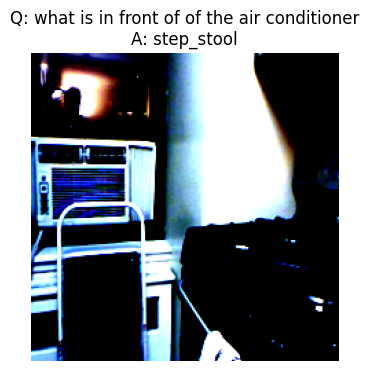

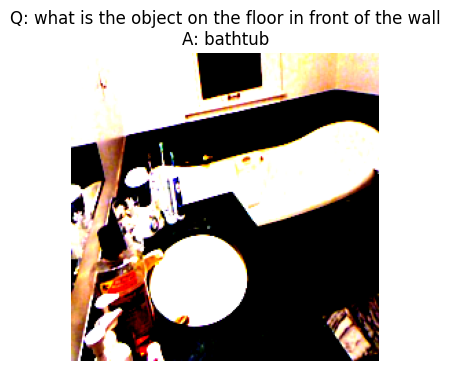

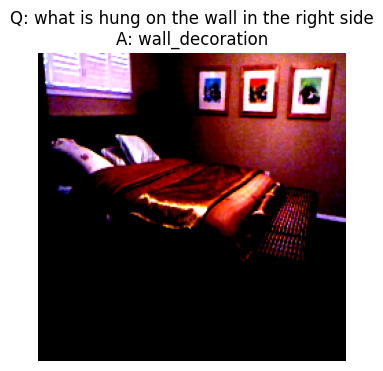

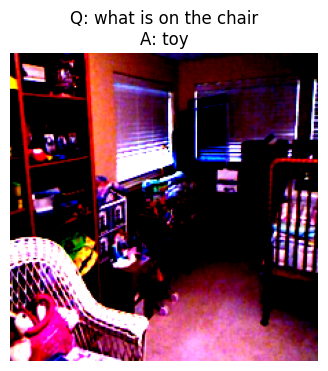

In [11]:
import matplotlib.pyplot as plt

for batch_idx, batch in enumerate(train_loader):
    images, input_ids, attention_mask, labels, boxes, features = batch
    print(input_ids[:9])
    # Decode the first few questions and answers
    decoded_questions = tokenizer.batch_decode(input_ids[:9], skip_special_tokens=True)
    reverse_label_map = {v: k for k, v in train_dataset.dataset.label_map.items()}
    decoded_answers = [reverse_label_map[label.item()] for label in labels[:9]]
    
    # Display the first few images with their questions and answers
    for i in range(min(5, len(images))):
        plt.figure(figsize=(4, 4))
        plt.imshow(images[i].permute(1, 2, 0).numpy())  # Convert CHW to HWC for display
        plt.axis("off")
        plt.title(f"Q: {decoded_questions[i]}\nA: {decoded_answers[i]}")
        plt.show()
    
    break


In [12]:
# question=(next(iter(train_loader))[1])
# print(type(question))
# batch = next(iter(train_loader))
# print(batch[3])

In [9]:
import torch
import torch.nn as nn
from transformers import BertModel
from torchvision import models
from torch.cuda.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint

class VQAModel(nn.Module):
    def __init__(self, num_answers, detr_feature_dim=256, num_boxes=100):
        """
        :param num_answers: Number of possible answers in VQA
        :param detr_feature_dim: Dimensionality of features from DETR
        :param num_boxes: Number of bounding boxes considered from DETR
        """
        super(VQAModel, self).__init__()
        # Image feature extractor
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove the final classification layer

        # Question feature extractor
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Fusion and final classification
         
        self.fc1 = nn.Linear(2048 + 768 + (detr_feature_dim+4) * num_boxes, 1024)
        self.fc2 = nn.Linear(1024, num_answers)
        self.dropout = nn.Dropout(0.5)

    def forward(self, images, input_ids, attention_mask, detr_features):
        """
        :param images: Batch of images
        :param input_ids: Tokenized question input IDs
        :param attention_mask: Attention mask for the BERT tokenizer
        :param detr_features: DETR features with shape (batch_size, num_boxes, feature_dim)
        """
        # print(f'y&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&')
        batch_size = images.size(0)
        # print(f'{batch_size}') #96
        # Extract image features
        image_features = checkpoint(self.cnn, images)  # Use checkpointing for ResNet
        # print(f'imag feat {image_features.shape}')
        # Extract question features
        outputs = checkpoint(self.bert, input_ids, attention_mask)
        question_features = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, 768)
        # print(f'que feat {question_features.shape}')

        # Flatten DETR features
        detr_features_flat = detr_features.view(batch_size, -1)  # shape: (batch_size, num_boxes * feature_dim)
        # print(detr_features_flat.shape)
        # Concatenate features
        combined_features = torch.cat((image_features, question_features, detr_features_flat), dim=1)
        # print(f'%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%{combined_features.shape}')

        # Classification
        x = self.fc1(combined_features)
        # print(f'heyyyyyyyy {x.shape}')
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [10]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

# Initialize the model
unique_answers = sorted(train_dataset.dataset.data['answer'].unique())

model = VQAModel(num_answers=len(unique_answers))
model.to(device)

# Training parameters
num_epochs = 1000
lr = 0.0001 
weight_decay = 1e-4
best_loss = float('inf')
best_model_state = None
patience = 1000  # Number of epochs to wait for improvement before stopping
early_stopping_counter = 0

# Initialize the optimizer and GradScaler for mixed precision training
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scaler = GradScaler()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define scheduler
scheduler_step_size = int(num_epochs * 0.25)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=scheduler_step_size)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/tmp/ipykernel_23/2505770012.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [11]:
# def calculate_accuracy(outputs, labels):
#     _, preds = torch.max(outputs, 1)
#     correct = (preds == labels).sum().item()
#     total = labels.size(0)
#     return correct / total

In [12]:
def calculate_accuracy(outputs, labels):
        _, preds = torch.max(outputs, 1)
        correct = (preds == labels).float().sum()
        accuracy = correct / labels.size(0)
        return accuracy.item()

In [13]:
import torch
from tqdm import tqdm
import wandb

def train_model(model, train_loader, val_loader, criterion, optimizer, scaler, device, num_epochs, patience, save_path, project_name):
    # Initialize wandb
    wandb.init(project=project_name)
    wandb.watch(model, log="all")

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_loss = float('inf')
    early_stopping_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for images, input_ids, attention_mask, labels, boxes, features in progress_bar:
            # print(images)
            # print(f"images type: {type(images)}")
            # print(f"input_ids type: {type(input_ids)}")
            # print(f"attention_mask type: {type(attention_mask)}")
            # print(f"labels type: {type(labels)}")
            # print(f"detr_features type: {type(boxes)}")
            # images = list(images)  # Convert tuple to a list

            # # Step 2: Concatenate all tensors along the batch dimension (dim=0)
            # images = torch.cat(images, dim=0)
            
            # Check the shape of the resulting tensor
            
            # print(images.shape)
            # print(images)
            # boxes = torch.tensor(boxes)
            # features = torch.tensor(features)
            # print(images)
            # print(f"images type: {type(images)}")
            # print(images)
            
            boxes = torch.tensor(boxes, dtype=torch.float32)
            # print(f'box {boxes.shape}')

            features = torch.tensor(features, dtype=torch.float32)
            # print(f'feature {features.shape}')
            
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            boxes = boxes.to(device)
            features= features.to(device)
            
            optimizer.zero_grad()
            detr_features = torch.cat([boxes, features], dim=-1) 
            # print(f'hiiii{detr_features.shape}')
            with torch.cuda.amp.autocast():
                outputs = model(images, input_ids, attention_mask,detr_features)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            accuracy = calculate_accuracy(outputs, labels)
            running_accuracy += accuracy

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = running_accuracy / len(train_loader)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        wandb.log({"train_loss": epoch_loss, "train_accuracy": epoch_accuracy, "epoch": epoch+1})

        model.eval()
        val_running_loss = 0.0
        val_running_accuracy = 0.0

        with torch.no_grad():
            val_progress_bar = tqdm(val_loader, desc="Validating", unit="batch")
            for images, input_ids, attention_mask, labels,boxes,features in val_progress_bar:
                
                
                # Check the shape of the resulting tensor
                # print(images.shape)
                images = images.to(device)

                boxes = torch.tensor(boxes, dtype=torch.float32)
                # print(boxes.shape)

                features = torch.tensor(features, dtype=torch.float32)
                # print(features.shape)
                boxes=boxes.to(device)
                features=features.to(device)
                detr_features = torch.cat([boxes, features], dim=-1)
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)
                

                with torch.cuda.amp.autocast():
                    outputs = model(images, input_ids, attention_mask,detr_features)
                    loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                accuracy = calculate_accuracy(outputs, labels)
                val_running_accuracy += accuracy

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_running_accuracy / len(val_loader)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        wandb.log({"val_loss": val_loss, "val_accuracy": val_accuracy, "epoch": epoch+1})

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss}, Training Accuracy: {epoch_accuracy}")
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

        # Check if the validation loss improved
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            early_stopping_counter = 0  # Reset counter if we get a new best loss
            print(f"Saving model with lowest validation loss: {best_loss:.4f}")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
                'best_loss': best_loss,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies
            }, save_path)
        else:
            early_stopping_counter += 1
            print(f"No improvement in validation loss for {early_stopping_counter} epochs.")

        # Check for early stopping
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    # Save the final metrics
    metrics = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

    wandb.finish()
    
    return metrics

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    def calculate_accuracy(outputs, labels):
        _, preds = torch.max(outputs, 1)
        correct = (preds == labels).float().sum()
        accuracy = correct / labels.size(0)
        return accuracy.item()

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating", unit="batch")
        for images, input_ids, attention_mask, labels,boxes,features in progress_bar:

            boxes = torch.tensor(boxes, dtype=torch.float32)
                # print(boxes.shape)

            features = torch.tensor(features, dtype=torch.float32)
                # print(features.shape)
            
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            boxes=boxes.to(device)
            features=features.to(device)
            detr_features = torch.cat([boxes, features], dim=-1)
            
            with torch.cuda.amp.autocast():
                outputs = model(images, input_ids, attention_mask,detr_features)
                loss = criterion(outputs, labels)

            running_loss += loss.item()
            accuracy = calculate_accuracy(outputs, labels)
            running_accuracy += accuracy

    loss = running_loss / len(data_loader)
    accuracy = running_accuracy / len(data_loader)

    print(f"Loss: {loss}, Accuracy: {accuracy}")

    return loss, accuracy

In [ ]:
import json

metrics = train_model(model, train_loader, val_loader, criterion, optimizer, scaler, device, num_epochs, patience, "/kaggle/working/best_model.pth", "VQA_BASELINE(ResNet50-Bert)")
with open("/kaggle/working/metrics.json", "w") as f:
    json.dump(metrics, f)

wandb: Currently logged in as: muskanmotwani_24rco01 (muskanmotwani_24rco01-delhi-technological-university). Use `wandb login --relogin` to force relogin


Epoch 1/1000:   0%|          | 0/125 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/tmp/ipykernel_23/263235940.py:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  boxes = torch.tensor(boxes, dtype=torch.float32)
/tmp/ipykernel_23/263235940.py:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  boxes = torch.tensor(boxe

Epoch 1/1000, Training Loss: 6.819305908203125, Training Accuracy: 0.03425
Validation Loss: 5.978480279445648, Validation Accuracy: 0.0634765625
Saving model with lowest validation loss: 5.9785


Epoch 2/1000:   0%|          | 0/125 [00:00<?, ?batch/s]/tmp/ipykernel_23/263235940.py:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  boxes = torch.tensor(boxes, dtype=torch.float32)
/tmp/ipykernel_23/263235940.py:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  boxes = torch.tensor(boxes, dtype=torch.float32)
/tmp/ipykernel_23/263235940.py:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting

In [19]:
# # Plot the result
# # Load the saved metrics
# with open("/kaggle/working/metrics.json", "r") as f:
#     metrics = json.load(f)

# train_losses = metrics["train_losses"]
# val_losses = metrics["val_losses"]
# train_accuracies = metrics["train_accuracies"]
# val_accuracies = metrics["val_accuracies"]

# # Plot the metrics
# epochs = range(1, len(train_losses) + 1)

# plt.figure(figsize=(14, 5))

# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_losses, label='Training Loss')
# plt.plot(epochs, val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss')

# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Training and Validation Accuracy')

# plt.tight_layout()
# plt.show()

In [20]:
import torch
import torch.nn as nn
from transformers import BertModel
from torchvision import models

class VQAModel_trained(nn.Module):
    def __init__(self, num_answers, detr_feature_dim=256, num_boxes=100):
        """
        :param num_answers: Number of possible answers in VQA.
        :param detr_feature_dim: Dimensionality of DETR features (default: 256).
        :param num_boxes: Number of bounding boxes considered (default: 100).
        """
        super(VQAModel_trained, self).__init__()
        # Image feature extractor
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove the final classification layer

        # Question feature extractor
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Fusion and final classification
        self.fc1 = nn.Linear(2048 + 768 + (detr_feature_dim+4) * num_boxes, 1024)  # Include DETR feature dimensions
        self.fc2 = nn.Linear(1024, num_answers)
        self.dropout = nn.Dropout(0.5)

    def forward(self, images, input_ids, attention_mask, detr_features):
        """
        Forward pass for the model.
        :param images: Batch of images.
        :param input_ids: Tokenized question input IDs.
        :param attention_mask: Attention mask for BERT tokenization.
        :param detr_features: DETR features with shape (batch_size, num_boxes, feature_dim).
        """
        batch_size = images.size(0)

        # Extract image features
        image_features = self.cnn(images)  # Shape: (batch_size, 2048)

        # Extract question features
        outputs = self.bert(input_ids, attention_mask)
        question_features = outputs.last_hidden_state[:, 0, :]  # Shape: (batch_size, 768)

        # Flatten DETR features
        detr_features_flat = detr_features.view(batch_size, -1)  # Shape: (batch_size, num_boxes * feature_dim)

        # Concatenate features
        combined_features = torch.cat((image_features, question_features, detr_features_flat), dim=1)

        # Classification
        x = self.fc1(combined_features)  # Shape: (batch_size, 1024)
        x = self.dropout(x)
        x = self.fc2(x)  # Shape: (batch_size, num_answers)
        return x


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unique_answers = sorted(train_dataset.dataset.data['answer'].unique())
print(len(unique_answers))
model = VQAModel_trained(num_answers=len(unique_answers))  # Adjust num_answers based on your dataset
model.to(device)

# Load the best model checkpoint
checkpoint_path = "/kaggle/working/best_model.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

print("Best model loaded successfully.")

10


/tmp/ipykernel_23/1636654785.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Best model loaded successfully.


In [22]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Example usage
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
feature_path = "/kaggle/working/detr_testfeatures.pkl"    # Path to save or load DETR features

# # Initialize DETR processor and model
# detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
# detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Set DETR model to evaluation mode
detr_model.eval()
test_dataset = VQADataset('/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_eval.csv', '/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images',detr_processor=detr_processor,
    detr_model=detr_model, transform=transform,feature_path=feature_path)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,collate_fn=lambda x: collate_fn(x, tokenizer),)

print("Test data loader prepared successfully.")

                                    question              answer  image_id
2213  what is on the left side of the blinds             picture  image676
2072             what are objects on the bed  bed_sheets, pillow  image921
1394               what is the on the hanger               towel  image504
2152         how many blue colour lights are                   2  image119
1058       what id to the right of the chair            computer  image454
unique ans 10
data[answer]: 2213               picture
2072    bed_sheets, pillow
1394                 towel
2152                     2
1058              computer
2475       decoration_item
1910                pillow
810             bed_sheets
859                 mirror
1918                bottle
Name: answer, dtype: object
Test data loader prepared successfully.


In [23]:
# for batch in test_loader:
#     print(len(batch))

In [24]:
# print(test_loader)
# for images, input_ids, attention_mask, labels,boxes,features in test_loader:
#     boxes = torch.tensor(boxes, dtype=torch.float32)
#             # print(f'box {boxes.shape}')

#     features = torch.tensor(features, dtype=torch.float32)
#             # print(f'feature {features.shape}')
            
#     images = images.to(device)
#     input_ids = input_ids.to(device)
#     attention_mask = attention_mask.to(device)
#     labels = labels.to(device)
#     boxes = boxes.to(device)
#     features= features.to(device)
    
#     evaluate_model(model, test_loader, criterion, device)


In [25]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)

Evaluating:   0%|          | 0/10 [00:00<?, ?batch/s]/tmp/ipykernel_23/3860894670.py:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  boxes = torch.tensor(boxes, dtype=torch.float32)
/tmp/ipykernel_23/2057604534.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(boxes, dtype=torch.float32)
/tmp/ipykernel_23/2057604534.py:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float32)
/tmp/ip

Loss: 11.75703125, Accuracy: 0.0


In [26]:
!pip -q install sentence-transformers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sentence_transformers import SentenceTransformer, util

# Load Sentence-BERT model
model_sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Function to calculate similarity using Sentence-BERT
def sbert_similarity(sentence1, sentence2):
    embeddings1 = model_sbert.encode(sentence1, convert_to_tensor=True)
    embeddings2 = model_sbert.encode(sentence2, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    return cosine_scores.item()

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [28]:
def preprocess_answer(answer):
    # Remove underscores from the answer
    return answer.replace('_', ' ')

In [29]:
# Load answer space for mapping
with open(os.path.join("/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

model.eval()
test_losses = []
test_accuracies = []
similarities = []

criterion = nn.CrossEntropyLoss()

In [30]:
# idx=6
# data_entry = train_dataset[idx]
# print(data_entry)
# print(f"Index: {idx}, Question: {data_entry[1]}, Label: {data_entry[2]}")

Batch Index: 0, Sample Index: 0, Global Index: 0
Batch Label: 7, Dataset Label: 7
Question: what is on the left side of the blinds
Predicted: bed sheets, Actual: picture


/tmp/ipykernel_23/2485393376.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes, features = torch.tensor(boxes, dtype=torch.float32).to(device), torch.tensor(features, dtype=torch.float32).to(device)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

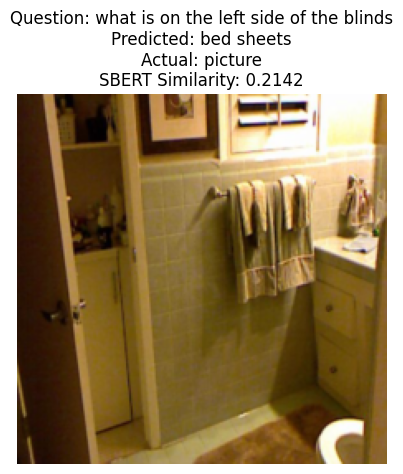

Batch Index: 1, Sample Index: 0, Global Index: 1
Batch Label: 2, Dataset Label: 2
Question: what are objects on the bed
Predicted: towel, Actual: bed sheets, pillow


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

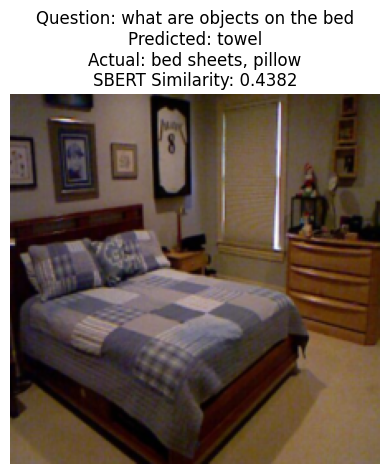

Batch Index: 2, Sample Index: 0, Global Index: 2
Batch Label: 9, Dataset Label: 9
Question: what is the on the hanger
Predicted: bed sheets, Actual: towel


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

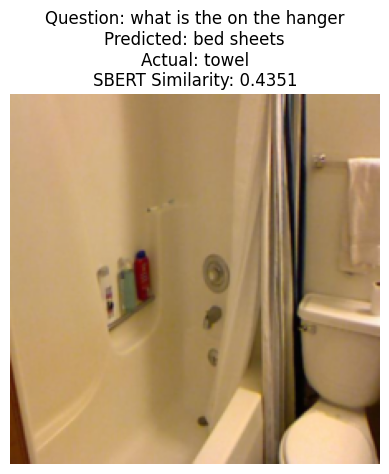

Batch Index: 3, Sample Index: 0, Global Index: 3
Batch Label: 0, Dataset Label: 0
Question: how many blue colour lights are
Predicted: computer, Actual: 2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

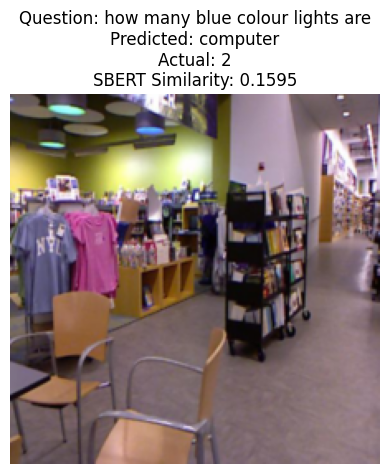

Batch Index: 4, Sample Index: 0, Global Index: 4
Batch Label: 4, Dataset Label: 4
Question: what id to the right of the chair
Predicted: bed sheets, Actual: computer


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

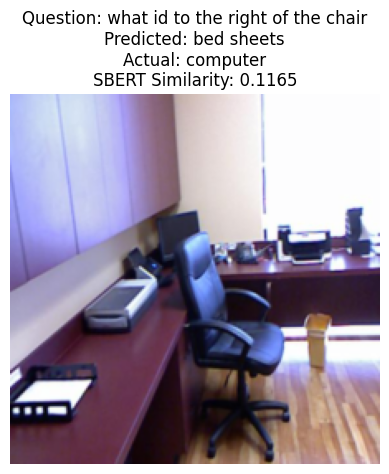

Batch Index: 5, Sample Index: 0, Global Index: 5
Batch Label: 5, Dataset Label: 5
Question: what is stuck on the wall
Predicted: towel, Actual: decoration item


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

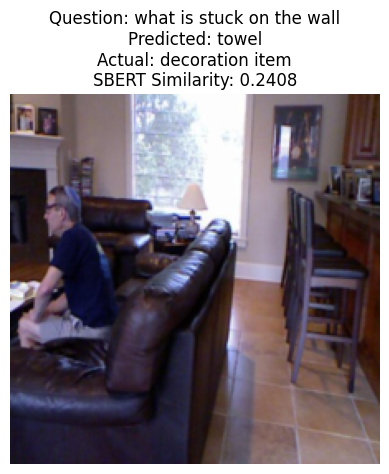

Batch Index: 6, Sample Index: 0, Global Index: 6
Batch Label: 8, Dataset Label: 8
Question: what is on the sofa
Predicted: mirror, Actual: pillow


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

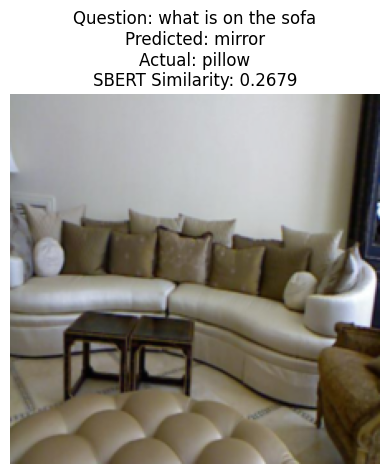

Batch Index: 7, Sample Index: 0, Global Index: 7
Batch Label: 1, Dataset Label: 1
Question: what is on bed
Predicted: towel, Actual: bed sheets


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

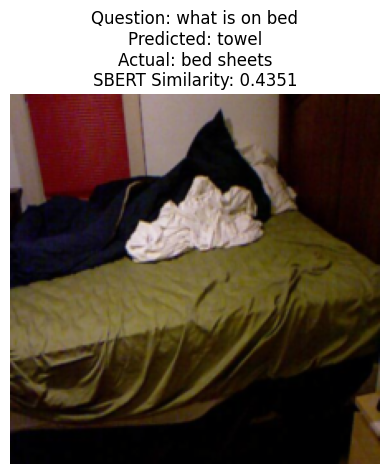

Batch Index: 8, Sample Index: 0, Global Index: 8
Batch Label: 6, Dataset Label: 6
Question: what is on the left side of the wooden box
Predicted: bed sheets, Actual: mirror


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

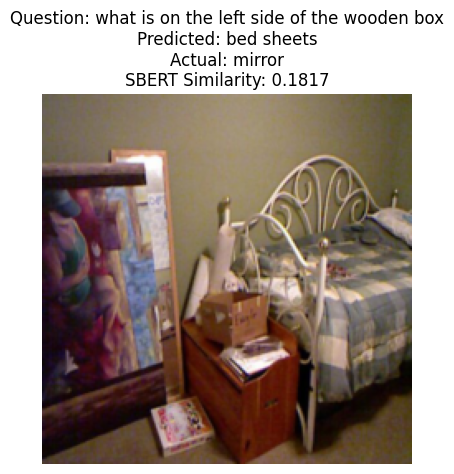

Batch Index: 9, Sample Index: 0, Global Index: 9
Batch Label: 3, Dataset Label: 3
Question: what is in the stand
Predicted: computer, Actual: bottle


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

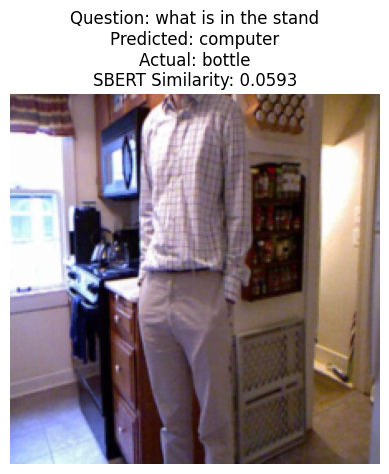

Average SBERT Similarity: 0.1274


In [31]:
with torch.no_grad():
    for batch_idx, (images, input_ids, attention_mask, labels, boxes, features) in enumerate(test_loader):
        for sample_idx in range(len(labels)):
            # Adjust for Subset (global index)
            global_idx = test_loader.dataset.indices[batch_idx * len(labels) + sample_idx]
            dataset_entry = test_dataset[global_idx]
            
            # Print for debugging
            print(f"Batch Index: {batch_idx}, Sample Index: {sample_idx}, Global Index: {global_idx}")
            print(f"Batch Label: {labels[sample_idx]}, Dataset Label: {dataset_entry[2]}")
            print(f"Question: {dataset_entry[1]}")
        boxes, features = torch.tensor(boxes, dtype=torch.float32).to(device), torch.tensor(features, dtype=torch.float32).to(device)
        
        detr_features = torch.cat([boxes, features], dim=-1)
        # Move tensors to device
        images, input_ids, attention_mask,boxes, features, labels = (
            images.to(device),
            input_ids.to(device),
            attention_mask.to(device),
            boxes.to(device),
            features.to(device),
            labels.to(device),
        )
        

        # Model prediction and loss
        outputs = model(images, input_ids, attention_mask, detr_features)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        _, preds = torch.max(outputs, 1)
        accuracy = calculate_accuracy(outputs, labels)
        test_accuracies.append(accuracy)

        unique_answers = sorted(test_dataset.data['answer'].unique())

        # Map predictions and labels to answers
        for pred, label in zip(preds, labels):
            predicted_answer = preprocess_answer(unique_answers[pred.item()])
            actual_answer = preprocess_answer(unique_answers[label.item()])

            print(f"Predicted: {predicted_answer}, Actual: {actual_answer}")

            # Compute similarity
            similarity = sbert_similarity(predicted_answer, actual_answer)
            test_accuracies.append(similarity)

        # Display images with questions and answers
        image = images[0].cpu().squeeze().permute(1, 2, 0).numpy()
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        question = dataset_entry[1]
        plt.imshow(image)
        plt.title(f"Question: {question}\nPredicted: {predicted_answer}\nActual: {actual_answer}\nSBERT Similarity: {similarity:.4f}")
        plt.axis("off")
        plt.show()

        if batch_idx >= 49:  # Limit displayed samples
            break

# Compute and print average similarity
average_similarity = np.mean(test_accuracies)
print(f"Average SBERT Similarity: {average_similarity:.4f}")


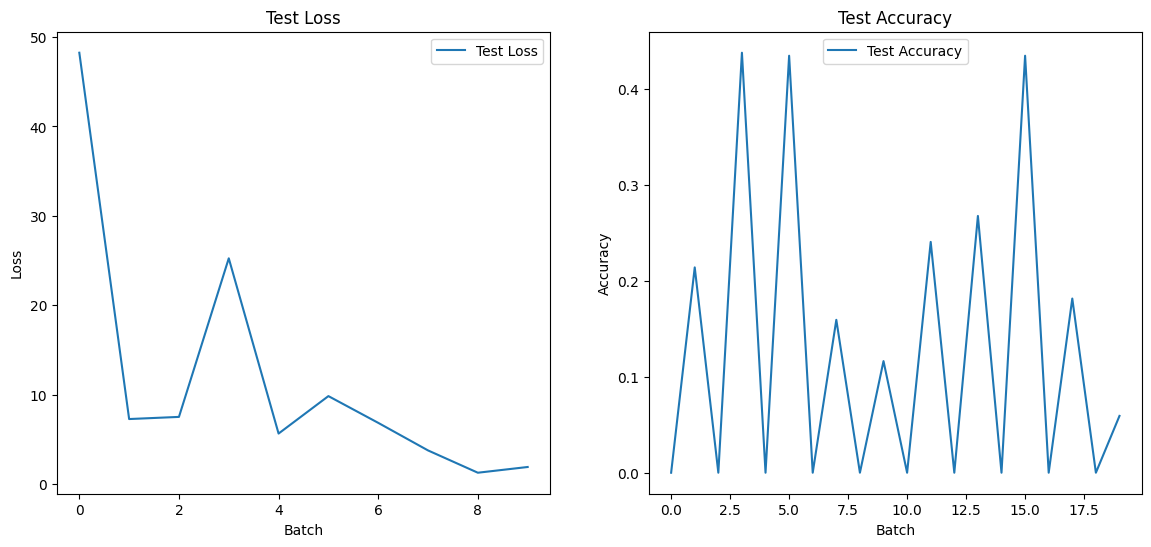

In [32]:
# # Plot test accuracy and test loss
plt.figure(figsize=(14, 6))

# Test Loss
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

# Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()

In [33]:
# # Similarity
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 1, 1)
# plt.plot(similarities, label='SBERT Similarity')
# plt.xlabel('Batch')
# plt.ylabel('Similarity')
# plt.title('SBERT Similarity')
# plt.legend()
# plt.show()